In [1]:
%load_ext autoreload
%autoreload 2 

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import seaborn.objects as so
import shap
import xgboost as xgb 


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from src.data_processing.pipelines.custom_transformers.PreprocessingTransformer import PreprocessingTransformer

# Reproduce processing pipeline 

In [7]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'
df = pd.read_parquet(DATA_PATH)
df


,mouse_id,day,event,sensor,time,trial,signal,action,latency,sex,learning_phase,trial_count
0,12,5,cue,D2,-25.000000,0,-0.155359,escape,0.00,F,0,115
1,12,5,cue,D2,-24.901531,0,-0.420553,escape,0.00,F,0,115
2,12,5,cue,D2,-24.803064,0,-1.592294,escape,0.00,F,0,115
3,12,5,cue,D2,-24.704596,0,-1.268734,escape,0.00,F,0,115
4,12,5,cue,D2,-24.606127,0,-0.210176,escape,0.00,F,0,115
...,...,...,...,...,...,...,...,...,...,...,...,...
5860105,1,4,escape,D1,19.606127,1,0.299603,avoid,7.54,F,0,87
5860106,1,4,escape,D1,19.704596,1,-0.249408,avoid,7.54,F,0,87
5860107,1,4,escape,D1,19.803064,1,-0.486369,avoid,7.54,F,0,87
5860108,1,4,escape,D1,19.901531,1,-0.146374,avoid,7.54,F,0,87


##  I need to scale the data individually before I melt, but I need to do this in such a way that it is integrated into the pipeline. I think the way to do this, is to use a custom transformer mixmin, but esssentially I need to rewrite the pipeline because it is a mess now

In [5]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'
def tweak_df(df):
  def standard_scale(df_):
    scaler = StandardScaler().set_output(transform='pandas')
    df_cat_cols = df_.select_dtypes(exclude = np.number)
    num_cols = df_.select_dtypes(include = np.number)
    df_to_scale = num_cols.drop(columns='ratio_avoid')
    df_scaled = scaler.fit_transform(df_to_scale)
    
    
    scaled_df = (pd.concat([df_cat_cols, df_scaled], axis = 1)
                 .assign(ratio_avoid = df_.ratio_avoid)
                 .pivot_table(index = "ratio_avoid",columns = "sensor", values =[col for col in df_.columns if col not in ["ratio_avoid", "sensor"]])

    )
    scaled_df.columns = ["_".join(col) for col in scaled_df.columns]
    
    return scaled_df.reset_index()

  cols_to_drop = ["event", "action", "sex","mouse_id", "day", "trial_count", "trial", "num_avoids", "max_trial"]
      

  return (
      df
      .drop(columns = cols_to_drop)
      .pipe(standard_scale)
      )


    

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data(drop_na=True)
                      # .query_by_col(query = "sensor!= 'D1'")
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .pipe_custom(tweak_df)
                      .split_by_ratio(target = "ratio_avoid")
                      .transform_data()

)

processor_pipe.processed_data



,ratio_avoid,neg_signal_trapz_D1,neg_signal_trapz_D2,neg_signal_trapz_DA,pos_signal_trapz_D1,pos_signal_trapz_D2,pos_signal_trapz_DA,signal_max_D1,signal_max_D2,signal_max_DA,signal_min_D1,signal_min_D2,signal_min_DA,signal_trapz_D1,signal_trapz_D2,signal_trapz_DA
0,0.035714,0.777201,NaN,-0.200171,-0.167494,NaN,-0.142067,-0.396253,NaN,1.087215,0.953303,NaN,0.293381,0.373209,NaN,-0.201400
1,0.107143,0.371384,NaN,-0.281731,0.281357,NaN,0.115114,-0.197021,NaN,0.695477,-0.153152,NaN,-0.111190,0.383769,NaN,-0.104364
2,0.142857,0.574426,NaN,-0.382588,0.375379,NaN,0.284269,-0.012601,NaN,0.122940,0.416203,NaN,0.182950,0.559588,NaN,-0.068996
3,0.178571,-0.108378,0.005225,-0.306835,0.303582,-0.796330,0.153967,-0.423229,-0.921522,0.272280,-0.154607,-0.036863,-0.698674,0.107249,-0.449518,-0.097409
4,0.214286,NaN,0.258714,-0.683675,NaN,-0.414240,-0.052366,NaN,-0.854927,0.243540,NaN,0.197013,-0.095514,NaN,-0.079544,-0.441818
5,0.222222,0.683600,NaN,-0.368158,-0.143981,NaN,0.178491,-0.666207,NaN,0.478299,0.740225,NaN,0.440286,0.330162,NaN,-0.120427
6,0.250000,NaN,0.727400,-0.675608,NaN,-0.083954,-0.220973,NaN,-0.164746,0.049889,NaN,0.726348,0.267541,NaN,0.390681,-0.532799
7,0.285714,0.376520,NaN,0.206339,0.255152,NaN,-0.335111,0.266418,NaN,1.871455,0.073071,NaN,0.567294,0.371968,NaN,-0.066130
8,0.321429,NaN,-0.333757,-0.326976,NaN,-0.394160,0.241563,NaN,-0.789991,0.480415,NaN,-1.193483,0.272896,NaN,-0.425213,-0.059754
9,0.357143,NaN,0.434004,-0.043974,NaN,0.037221,0.013157,NaN,-1.097784,0.724655,NaN,1.156536,-0.587568,NaN,0.282732,-0.019024


# Train Regressor using opimtized parameteres

In [6]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evalulate on dev set

In [7]:
mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}") 
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.004722644060928159
 MSE for optimzied model on development test is 0.14983004603045974
 MSE for optimzied model on test is 0.06456523343789564


# Predict on test set

In [8]:
predicted_performance = model.predict(processor_pipe.X_test)

In [9]:
processor_pipe.processor.named_transformers_["num"]

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

# Plotting test set vs inference 


In [10]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        # cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols #+ cat_cols


def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,neg_signal_trapz_D1,neg_signal_trapz_D2,neg_signal_trapz_DA,pos_signal_trapz_D1,pos_signal_trapz_D2,pos_signal_trapz_DA,signal_max_D1,signal_max_D2,signal_max_DA,signal_min_D1,signal_min_D2,signal_min_DA,signal_trapz_D1,signal_trapz_D2,signal_trapz_DA,inference_cat,ratio_avoid
0,3.062828e-01,3.962457e-08,-0.143657,-3.219753e-01,-4.742144e-09,-0.153647,-3.469217e-01,2.406185e-08,-0.199025,2.377257e-01,4.218763e-10,0.286225,1.193576e-02,-2.249253e-08,-0.202077,predicted_values,0.903098
1,1.398210e-08,-2.738655e+00,0.402862,1.039689e-08,9.416454e-01,-1.103334,-5.370822e-08,1.054183e+00,0.827956,1.262461e-09,-2.521408e+00,-0.942732,2.960891e-09,-7.448860e-01,-0.477841,predicted_values,0.622374
2,1.398210e-08,-7.540407e-01,-1.804707,1.039689e-08,-6.326287e-02,-0.250044,-5.370822e-08,-3.083626e-01,-0.677319,1.262461e-09,-3.585418e-01,0.028425,2.960891e-09,-4.994537e-01,-1.394710,predicted_values,0.950882
3,9.295921e-01,1.523502e+00,-1.079193,-2.718314e+00,-5.872949e-01,-0.477137,-2.813328e+00,-8.305153e-01,-0.808403,1.438096e+00,5.790452e-01,-0.562036,-1.396540e+00,3.564573e-01,-1.057068,predicted_values,0.776093
4,1.398210e-08,-3.276976e+00,0.006751,1.039689e-08,-7.048346e-01,0.644946,-5.370822e-08,-7.239873e-01,-0.081185,1.262461e-09,-2.239866e+00,0.929274,2.960891e-09,-2.562928e+00,0.443677,predicted_values,0.613502
5,3.062828e-01,3.962457e-08,-0.143657,-3.219753e-01,-4.742144e-09,-0.153647,-3.469217e-01,2.406185e-08,-0.199025,2.377257e-01,4.218763e-10,0.286225,1.193576e-02,-2.249253e-08,-0.202077,true_values,0.464286
6,1.398210e-08,-2.738655e+00,0.402862,1.039689e-08,9.416454e-01,-1.103334,-5.370822e-08,1.054183e+00,0.827956,1.262461e-09,-2.521408e+00,-0.942732,2.960891e-09,-7.448860e-01,-0.477841,true_values,0.769231
7,1.398210e-08,-7.540407e-01,-1.804707,1.039689e-08,-6.326287e-02,-0.250044,-5.370822e-08,-3.083626e-01,-0.677319,1.262461e-09,-3.585418e-01,0.028425,2.960891e-09,-4.994537e-01,-1.394710,true_values,0.962963
8,9.295921e-01,1.523502e+00,-1.079193,-2.718314e+00,-5.872949e-01,-0.477137,-2.813328e+00,-8.305153e-01,-0.808403,1.438096e+00,5.790452e-01,-0.562036,-1.396540e+00,3.564573e-01,-1.057068,true_values,0.928571
9,1.398210e-08,-3.276976e+00,0.006751,1.039689e-08,-7.048346e-01,0.644946,-5.370822e-08,-7.239873e-01,-0.081185,1.262461e-09,-2.239866e+00,0.929274,2.960891e-09,-2.562928e+00,0.443677,true_values,0.321429


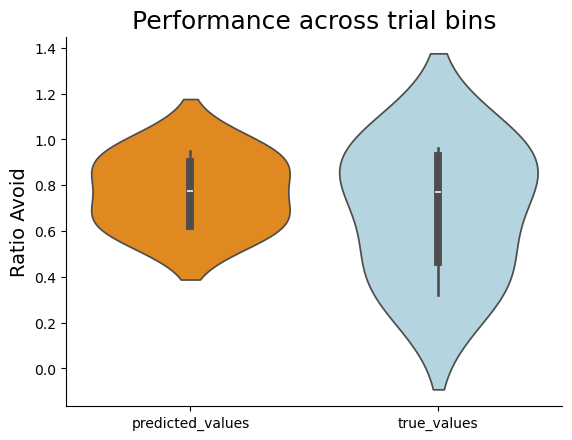

In [11]:
fig, ax = plt.subplots()
sns.violinplot(data=testing_df, x='inference_cat', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)




ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Performance across trial bins', fontsize = 18)
sns.despine()

---
# Feature Importance




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

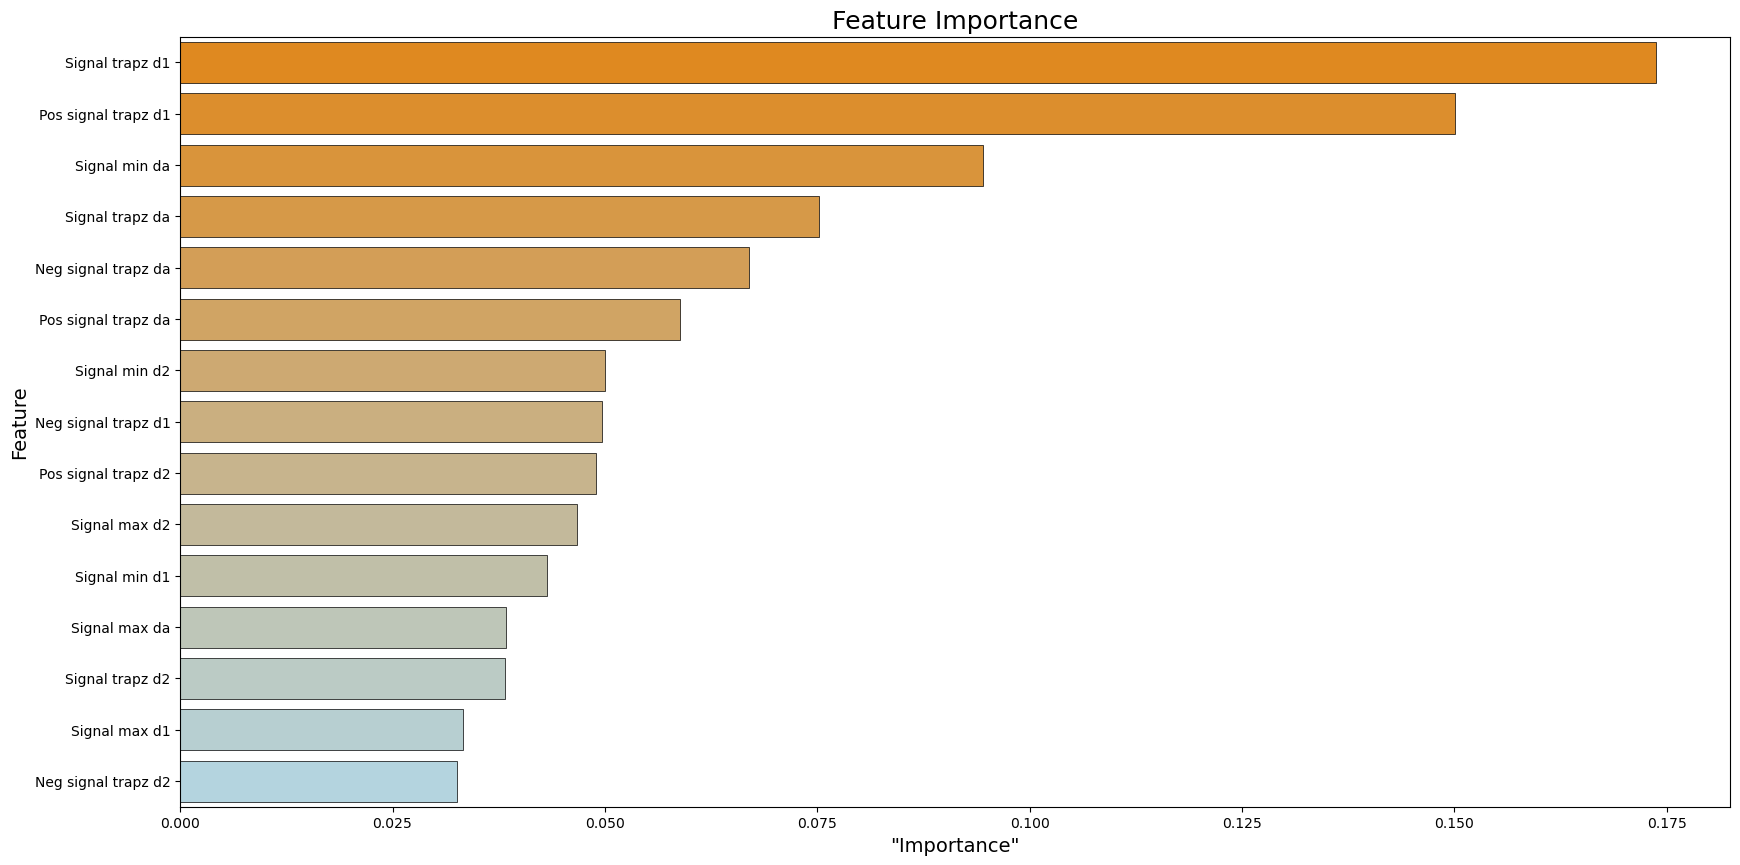

In [12]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(processor_pipe)
# cols_new = [col.removeprefix("sensor_event_variable_") for col in cols]
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

## SHAP from feature space

[09:24:33] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


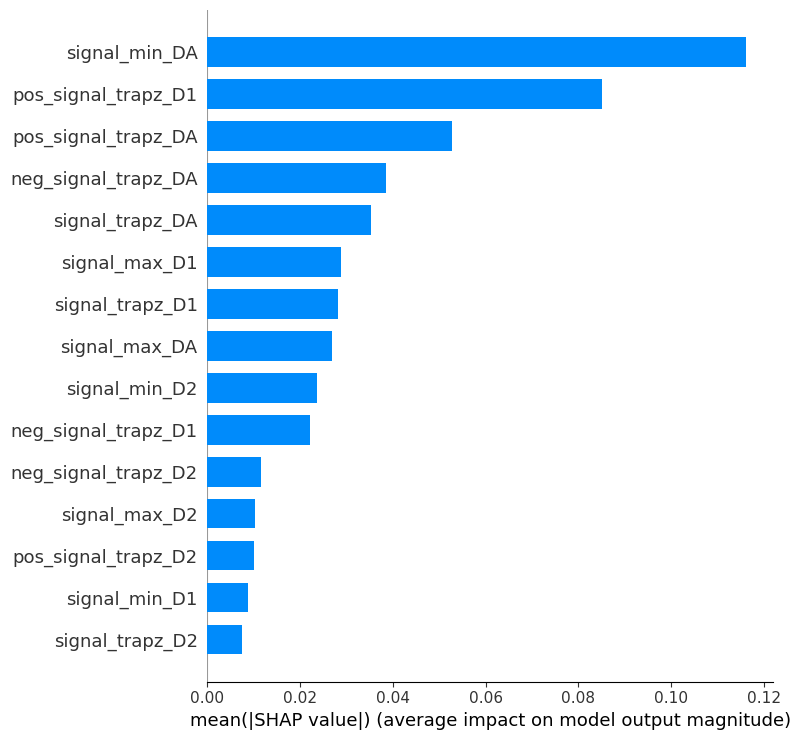

In [13]:

explainer = shap.TreeExplainer(model,processor_pipe.X_train)
explanation = explainer(processor_pipe.X_train)
explanation.feature_names = cols
shap.summary_plot(explanation, plot_type="bar")

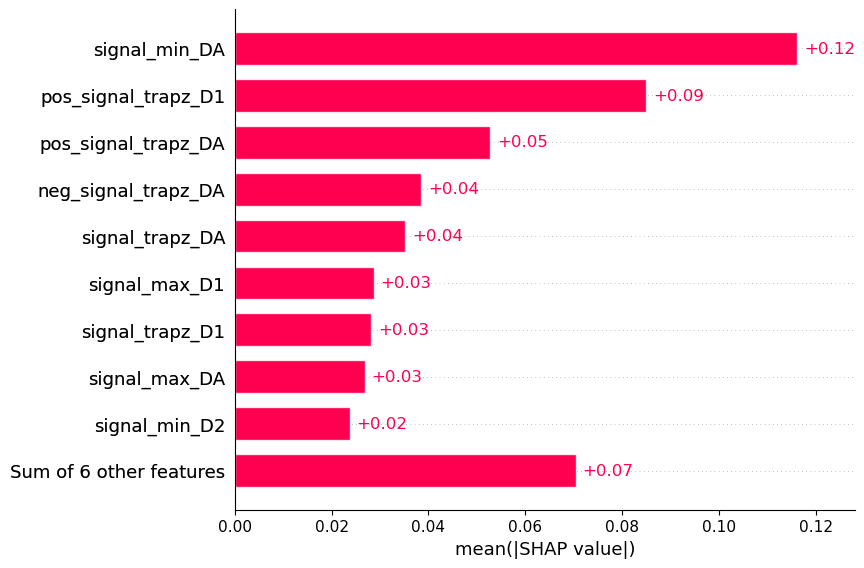

In [14]:
shap.plots.bar(explanation)

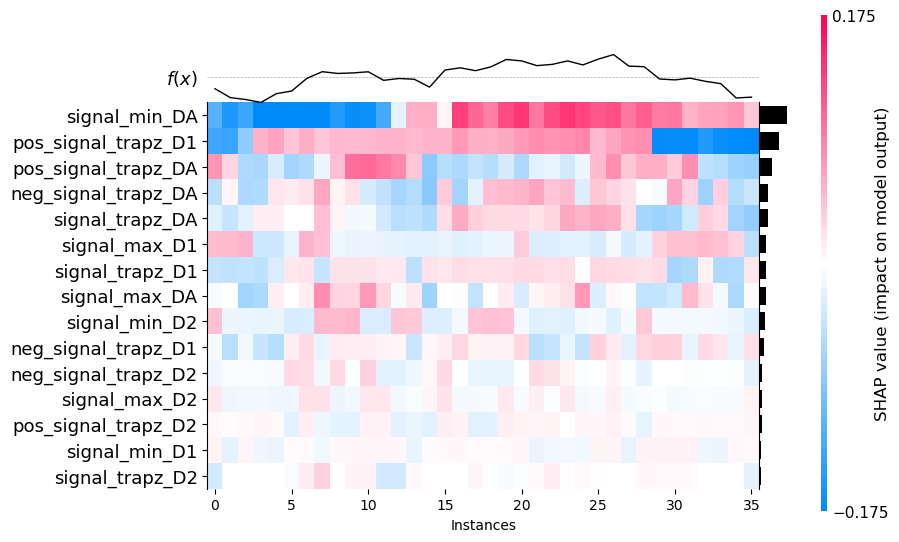

In [19]:
shap.plots.heatmap(explanation, max_display=20)

In [18]:
shap.plots.embedding(shap_values = explanation, ind=1)

ValueError: setting an array element with a sequence.

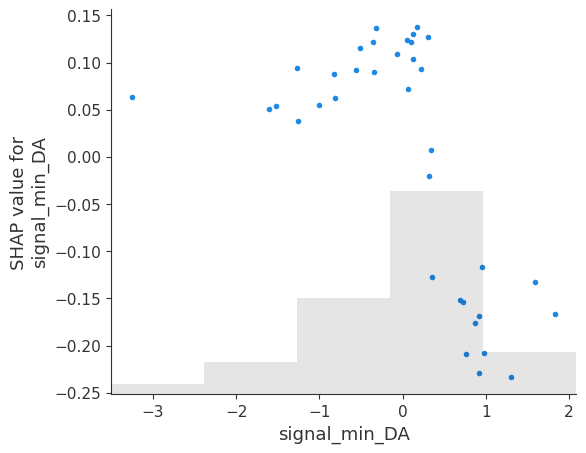

In [20]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(explanation[:, "signal_min_DA"])

# NO SCALING- this is hacked together through commenting out the standard scaler in the pipeline: to reproduce, write new pipeline

In [21]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'
def tweak_df(df):
  
  def pivot_rename(df_):

    piv_df =df_.pivot_table(index = "ratio_avoid",columns = "sensor", values =[col for col in df_.columns if col not in ["ratio_avoid", "sensor"]])

      
    piv_df.columns = ["_".join(col) for col in piv_df.columns]
      
    return piv_df.reset_index()

  cols_to_drop = ["event", "mouse_id", "day", "action", "sex", "trial_count", "trial", "num_avoids", "max_trial"]
      

  return (
      df
      .drop(columns = cols_to_drop)
      .pipe(pivot_rename)
      )


    

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data(drop_na=True)
                      # .query_by_col(query = "sensor!= 'D1'")
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .pipe_custom(tweak_df)
                      .split_by_ratio(target = "ratio_avoid")
                      .transform_data()

)



In [22]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)
predicted_performance = model.predict(processor_pipe.X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [23]:


mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}") 
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.004722644060928159
 MSE for optimzied model on development test is 0.14983004603045974
 MSE for optimzied model on test is 0.06456523343789564


In [24]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        # cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols #+ cat_cols


def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,neg_signal_trapz_D1,neg_signal_trapz_D2,neg_signal_trapz_DA,pos_signal_trapz_D1,pos_signal_trapz_D2,pos_signal_trapz_DA,signal_max_D1,signal_max_D2,signal_max_DA,signal_min_D1,signal_min_D2,signal_min_DA,signal_trapz_D1,signal_trapz_D2,signal_trapz_DA,inference_cat,ratio_avoid
0,3.062826e-01,1.160493e-07,-0.143658,-0.321976,1.324201e-07,-0.153647,-3.469220e-01,-3.481209e-07,-0.199025,2.377258e-01,-7.289341e-08,0.286225,1.193595e-02,1.085815e-08,-0.202077,predicted_values,0.903098
1,-9.747631e-08,-2.738655e+00,0.402862,0.000000,9.416456e-01,-1.103334,-2.240211e-07,1.054183e+00,0.827956,8.699349e-08,-2.521408e+00,-0.942732,-2.469849e-08,-7.448860e-01,-0.477841,predicted_values,0.622374
2,-9.747631e-08,-7.540411e-01,-1.804707,0.000000,-6.326315e-02,-0.250044,-2.240211e-07,-3.083624e-01,-0.677319,8.699349e-08,-3.585417e-01,0.028425,-2.469849e-08,-4.994537e-01,-1.394711,predicted_values,0.950882
3,9.295923e-01,1.523501e+00,-1.079193,-2.718314,-5.872955e-01,-0.477138,-2.813328e+00,-8.305153e-01,-0.808403,1.438096e+00,5.790450e-01,-0.562036,-1.396540e+00,3.564574e-01,-1.057068,predicted_values,0.776093
4,-9.747631e-08,-3.276976e+00,0.006751,0.000000,-7.048343e-01,0.644945,-2.240211e-07,-7.239872e-01,-0.081185,8.699349e-08,-2.239865e+00,0.929274,-2.469849e-08,-2.562928e+00,0.443677,predicted_values,0.613502
5,3.062826e-01,1.160493e-07,-0.143658,-0.321976,1.324201e-07,-0.153647,-3.469220e-01,-3.481209e-07,-0.199025,2.377258e-01,-7.289341e-08,0.286225,1.193595e-02,1.085815e-08,-0.202077,true_values,0.464286
6,-9.747631e-08,-2.738655e+00,0.402862,0.000000,9.416456e-01,-1.103334,-2.240211e-07,1.054183e+00,0.827956,8.699349e-08,-2.521408e+00,-0.942732,-2.469849e-08,-7.448860e-01,-0.477841,true_values,0.769231
7,-9.747631e-08,-7.540411e-01,-1.804707,0.000000,-6.326315e-02,-0.250044,-2.240211e-07,-3.083624e-01,-0.677319,8.699349e-08,-3.585417e-01,0.028425,-2.469849e-08,-4.994537e-01,-1.394711,true_values,0.962963
8,9.295923e-01,1.523501e+00,-1.079193,-2.718314,-5.872955e-01,-0.477138,-2.813328e+00,-8.305153e-01,-0.808403,1.438096e+00,5.790450e-01,-0.562036,-1.396540e+00,3.564574e-01,-1.057068,true_values,0.928571
9,-9.747631e-08,-3.276976e+00,0.006751,0.000000,-7.048343e-01,0.644945,-2.240211e-07,-7.239872e-01,-0.081185,8.699349e-08,-2.239865e+00,0.929274,-2.469849e-08,-2.562928e+00,0.443677,true_values,0.321429


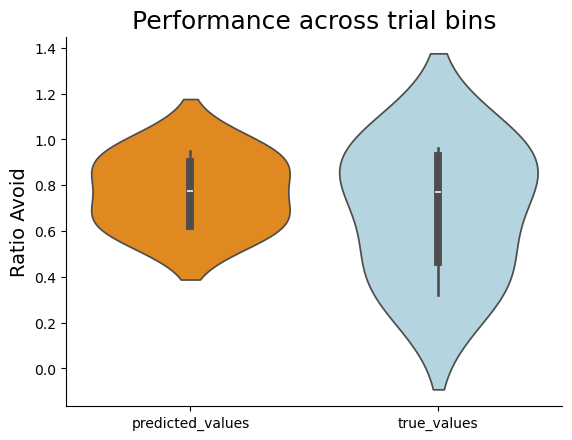

In [25]:
fig, ax = plt.subplots()
sns.violinplot(data=testing_df, x='inference_cat', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)




ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Performance across trial bins', fontsize = 18)
sns.despine()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

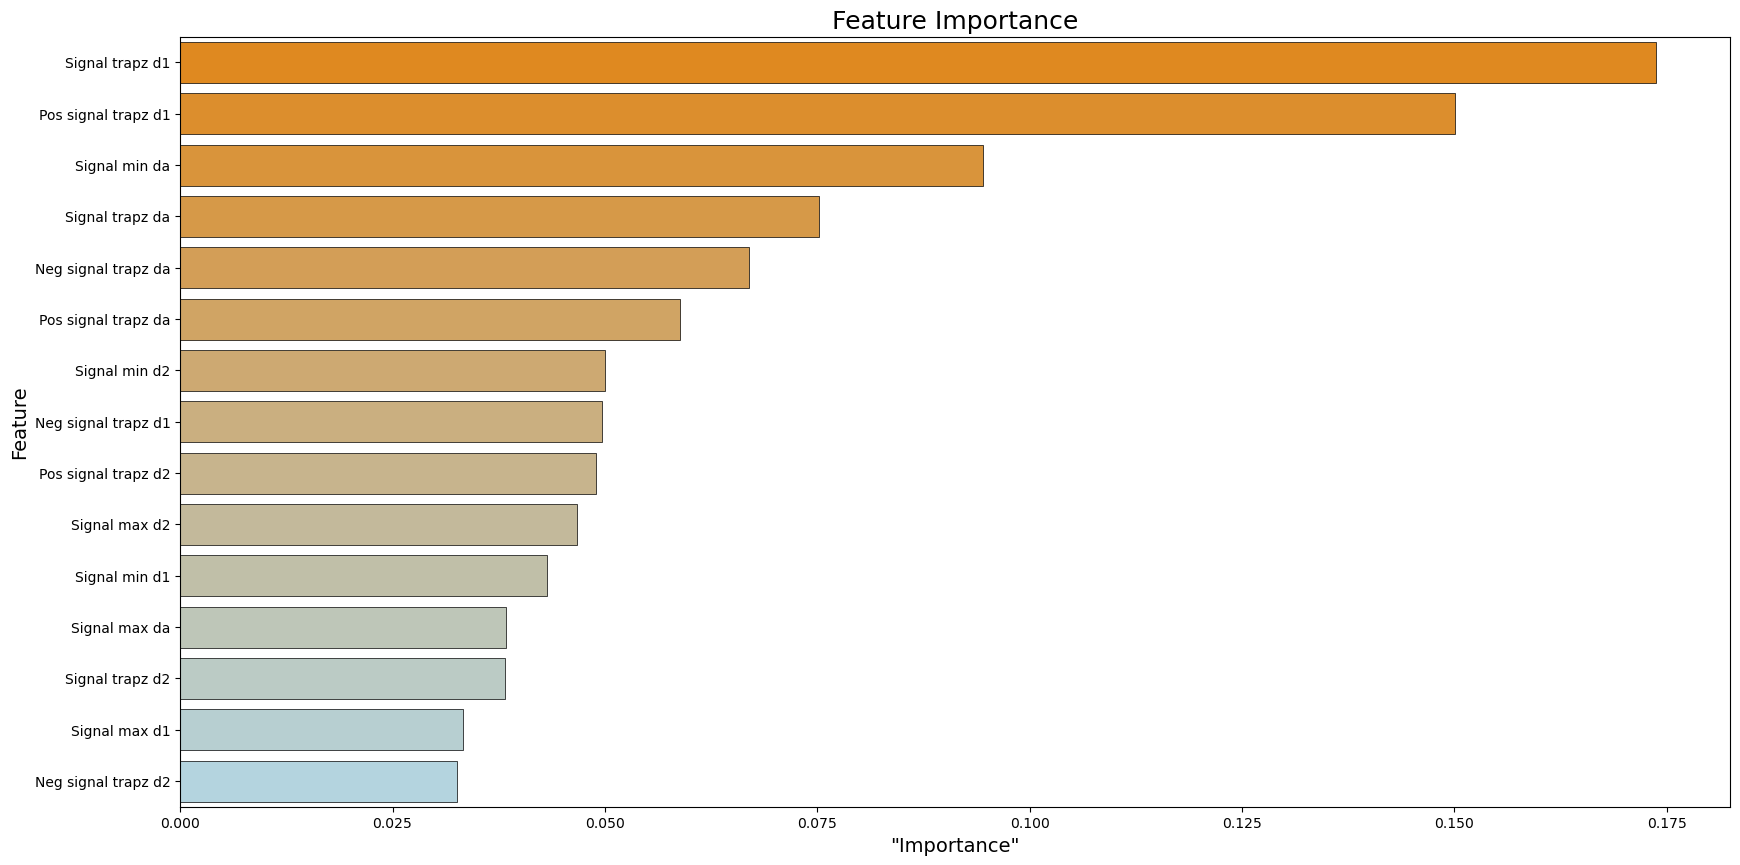

In [26]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(processor_pipe)
# cols_new = [col.removeprefix("sensor_event_variable_") for col in cols]
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

[09:26:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


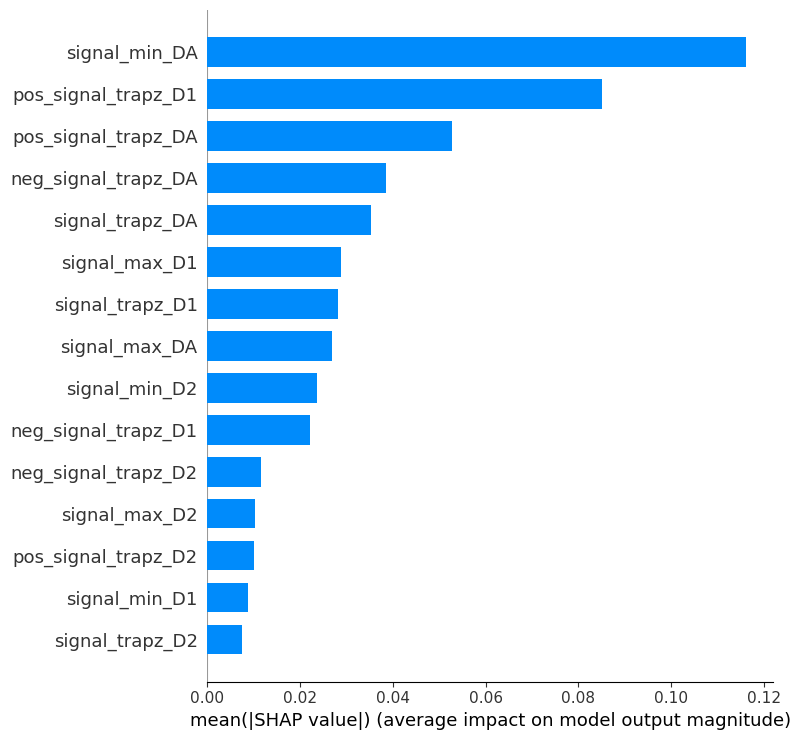

In [27]:

explainer = shap.TreeExplainer(model,processor_pipe.X_train)
explanation = explainer(processor_pipe.X_train)
explanation.feature_names = cols
shap.summary_plot(explanation, plot_type="bar")

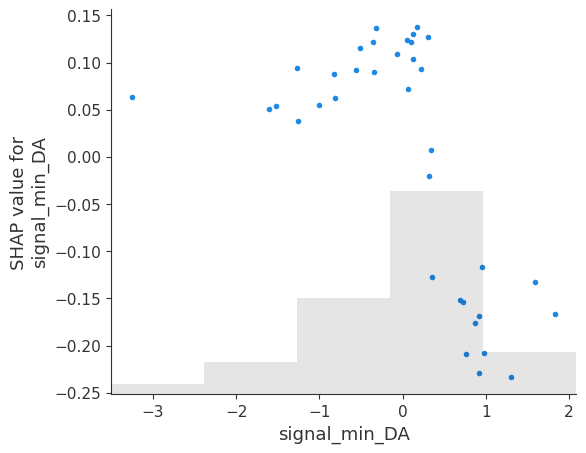

In [28]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(explanation[:, "signal_min_DA"])